# Imports

In [1]:
import ray

ray.shutdown()

In [176]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample tick dates

In [256]:
from bar_sampler import meta, sampler, stacked
from data_model import arrow_dataset, s3_backend

thresh = {
    # meta params
    'symbol': 'VTI',
    'start_date': '2019-10-10',
    'end_date': '2019-10-15',
    # filter
    'mad_value_winlen': 22,
    'mad_deviation_winlen': 1111,
    'mad_k': 17,  # 11
    'mad_diff': 'simple',
    'jma_winlen': 7,
    'jma_power': 2,
    # time batcher
    'batch_freq': '2s',
    # bar sampler params
    'renko_return': 'price_jma_return',
    'renko_size': 0.1,  # for simple runs
    'renko_reveral_multiple': 2,
    'renko_range_frac': 22,
    'renko_range_min_pct_value': 0.03,  # X% of symbol value to enforc min renko size
    'max_duration_td': dt.timedelta(minutes=33),
    'min_duration_td': dt.timedelta(seconds=33),
    'min_tick_count': 33,
    # label params
    'add_label': True,
    'reward_ratios': list(np.arange(2, 11, 0.5)),
}

In [72]:
s3_backend.list_symbols('trades')

['AEM',
 'AG',
 'AGI',
 'ASA',
 'AU',
 'AUY',
 'AXU',
 'BTG',
 'BVN',
 'CDE',
 'DRD',
 'EGO',
 'EXK',
 'FNV',
 'FSM',
 'GFI',
 'GLD',
 'GORO',
 'GSS',
 'HL',
 'HMY',
 'IAG',
 'KGC',
 'KL',
 'MAG',
 'MUX',
 'NEM',
 'NG',
 'OR',
 'PAAS',
 'PVG',
 'RGLD',
 'SA',
 'SAND',
 'SSRM',
 'SVM',
 'USAS',
 'VTI',
 'WPM']

In [257]:
# bd = meta.get_bar_date(thresh, date='2019-01-10')

bds = meta.get_bar_dates(thresh, ray_on=True)


2021-05-21 23:25:23,840	INFO worker.py:650 -- Calling ray.init() again after it has already been called.


(pid=31802) VTI 2019-10-09 trying to get data from local file...
(pid=31801) VTI 2019-10-10 trying to get data from local file...
(pid=31803) VTI 2019-10-14 trying to get data from local file...
(pid=31804) VTI 2019-10-11 trying to get data from local file...
(pid=31803) VTI 2019-10-15 trying to get data from local file...


<AxesSubplot:>

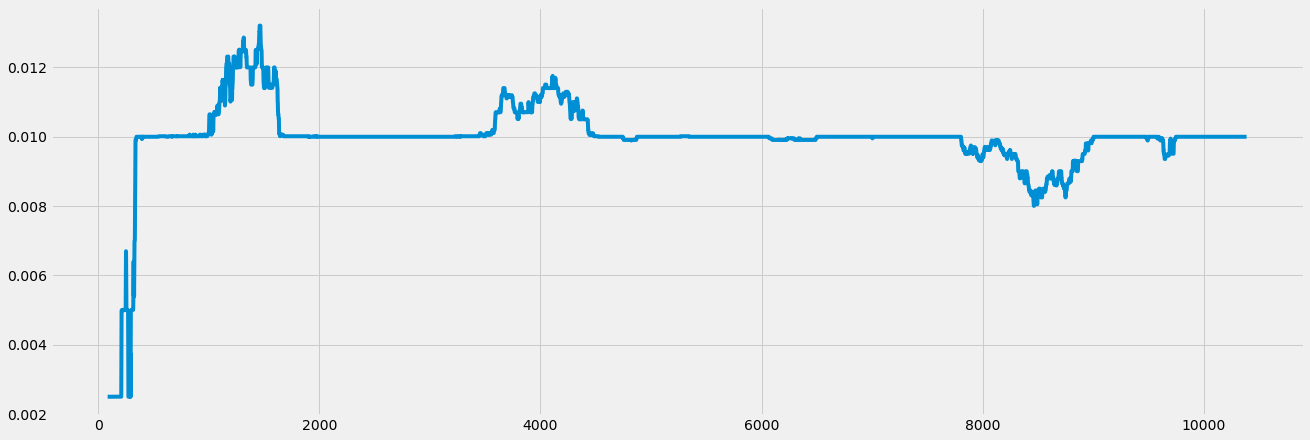

In [291]:
n = 3

bds[n]['ticks_df'].price_median_diff_median.plot()

<AxesSubplot:>

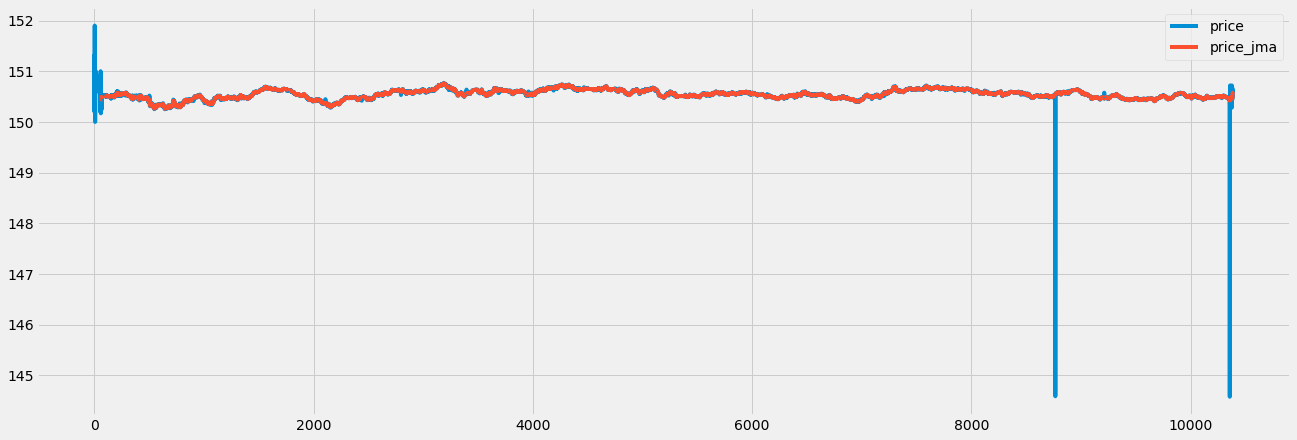

In [292]:
bds[n]['ticks_df'][['price', 'price_jma']].plot()

# bds[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

<AxesSubplot:xlabel='nyc_dt'>

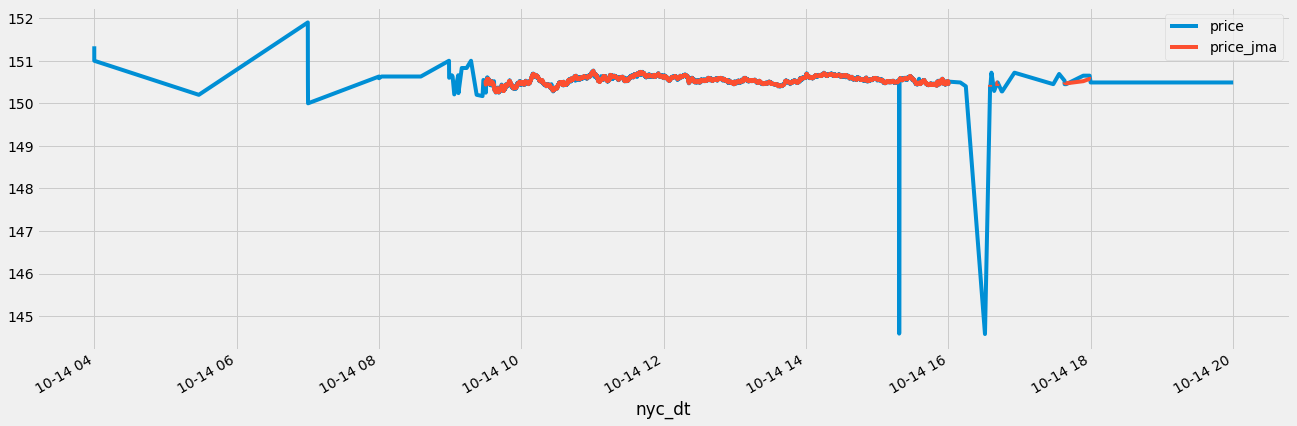

In [293]:
bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot()
# bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")

<AxesSubplot:>

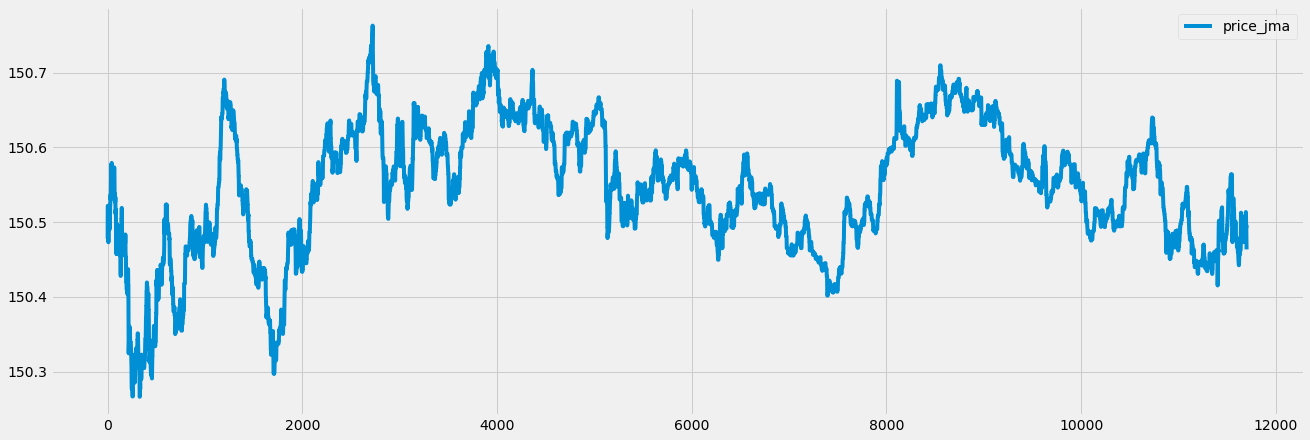

In [294]:
# bds[n]['batches_df'].set_index('close_at')[['price_jma']].ffill().plot()
bds[n]['batches_df'][['price_jma']].ffill().plot()

<AxesSubplot:>

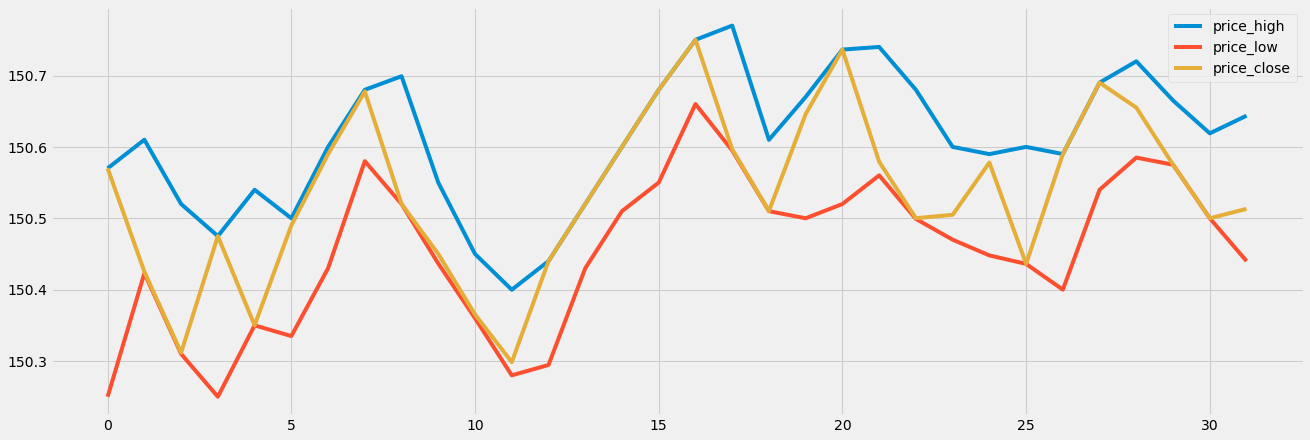

In [295]:
# bds[n]['bars_df'].set_index('close_at')[['price_vwap']].plot()

bds[n]['bars_df'][['price_high', 'price_low', 'price_close']].plot()

# opening_bars_df = bds[n]['bars_df'][bds[n]['bars_df'].open_at.dt.time <= dt.time(hour=9, minute=35)]

In [296]:
t=bds[n]['bars_df'].copy()
t.label_rrr.value_counts()/t.shape[0]

0.000000    0.406250
-2.000000   0.125000
-2.500000   0.062500
4.500000    0.062500
2.500000    0.062500
2.000000    0.062500
-5.000000   0.031250
-3.000000   0.031250
3.500000    0.031250
3.000000    0.031250
6.000000    0.031250
-4.500000   0.031250
-3.500000   0.031250
Name: label_rrr, dtype: float64

In [273]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

,date,bar_count,duration_min_median,price_range_mean,first_bar_open,last_bar_close
0,2019-10-09,45,5.700000,0.188003,2019-10-09 09:30:02-04:00,2019-10-09 15:59:34-04:00
1,2019-10-10,54,5.383333,0.189816,2019-10-10 09:30:06-04:00,2019-10-10 15:55:52-04:00
2,2019-10-11,67,3.433333,0.203324,2019-10-11 09:30:02-04:00,2019-10-11 15:59:16-04:00
3,2019-10-14,32,6.483333,0.155001,2019-10-14 09:30:02-04:00,2019-10-14 15:38:08-04:00
4,2019-10-15,40,8.550000,0.134391,2019-10-15 09:30:02-04:00,2019-10-15 15:44:20-04:00


In [274]:
stats_df.describe()

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

,bar_count,duration_min_median,price_range_mean
count,5.000000,5.000000,5.000000
mean,47.600000,5.910000,0.174107
std,13.464769,1.854297,0.028443
min,32.000000,3.433333,0.134391
25%,40.000000,5.383333,0.155001
50%,45.000000,5.700000,0.188003
75%,54.000000,6.483333,0.189816
max,67.000000,8.550000,0.203324


In [275]:
results = []

for date in bds:
    bars_df = date['bars_df'].copy()
    rrr = (abs(bars_df.label_rrr).value_counts() / bars_df.shape[0]).to_dict()
#     rrr = (abs(bars_df.label_rrr).value_counts()).to_dict()
    out = (date['ticks_df'].status.value_counts() / date['ticks_df'].shape[0]).to_dict()
    out.update({'date': date['date']})
    out.update(rrr)
    results.append(out)

pd.DataFrame(results)

,clean,filtered: MAD outlier,filtered: MAD warm-up,filtered: irregular conditions,filtered: ts diff,filtered: zero volume,date,0.0,2.0,4.5,3.5,2.5,3.0,4.0,6.0,5.5,5.0,7.0,10.5,6.5,10.0,9.5,9.0,8.5,8.0,7.5
0,0.992708,0.002601,0.002455,0.001356,0.000806,0.000073,2019-10-09,0.444444,0.155556,0.111111,0.088889,0.088889,0.066667,0.022222,0.022222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.988396,0.003032,0.003907,0.003265,0.001225,0.000175,2019-10-10,0.240741,0.111111,0.055556,0.074074,0.111111,0.129630,0.037037,NaN,0.055556,0.037037,0.037037,0.037037,0.018519,0.018519,0.018519,0.018519,NaN,NaN,NaN
2,0.990607,0.002625,0.002748,0.002543,0.001354,0.000123,2019-10-11,0.298507,0.089552,0.089552,0.059701,0.119403,0.044776,0.059701,0.044776,NaN,0.014925,NaN,0.044776,0.014925,0.029851,0.014925,0.014925,0.029851,0.014925,0.014925
3,0.981325,0.001155,0.006450,0.008279,0.002503,0.000289,2019-10-14,0.406250,0.187500,0.093750,0.062500,0.125000,0.062500,NaN,0.031250,NaN,0.031250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.984583,0.003182,0.004738,0.005870,0.001414,0.000212,2019-10-15,0.250000,0.200000,0.025000,NaN,0.150000,0.050000,0.050000,NaN,0.025000,0.025000,0.050000,0.050000,NaN,0.050000,NaN,0.025000,0.050000,NaN,NaN
